# Introduction

This project aims to leverage patient hospital data to predict readmissions using two distinct machine learning models: the Multilayer Perceptron (MLP) and the Kolmogorov-Arnold Network (KAN). The objective is to analyze and compare the performance of these models in predicting patient readmissions based on historical hospital data. This notebook is structured into several sections, including data loading, preprocessing, model training, evaluation, and a comparative analysis of the results obtained from both MLP and KAN models.

The MLP model, a type of feedforward artificial neural network, consists of multiple layers of nodes in a directed graph, with each layer fully connected to the next one. It utilizes backpropagation for training the network to model the relationship between input features and the target variable (readmission).

On the other hand, the KAN model represents a novel approach in machine learning, inspired by the Kolmogorov-Arnold representation theorem. It aims to capture the intrinsic geometry of data by mapping inputs to outputs through a series of functional transformations, offering a potentially more flexible and interpretable model compared to traditional neural networks.

The notebook will cover the following sections:
1. Load Data: Importing the patient data and preparing it for analysis.
2. Prepare Data: Preprocessing steps to clean and structure the data for modeling.
3. Model Training: Setting up the MLP and KAN models, followed by training on the preprocessed data.
4. Evaluation: Assessing the performance of each model in terms of accuracy, precision, recall, and other relevant metrics.
5. Results and Discussion: A comparative analysis of the MLP and KAN models based on their performance metrics, followed by insights and conclusions drawn from the study.

Through this comparative study, we aim to identify the strengths and limitations of each model in the context of predicting hospital readmissions, thereby providing valuable insights into the applicability and effectiveness of advanced machine learning techniques in healthcare analytics.

## Load data

In [11]:
import pandas as pd

df = pd.read_csv('patient_data.csv')

In [ ]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title='Profiling Report', minimal=True)
# profile.to_file("data_profile.html")

## Prepare data

In [3]:
from preprocessing import preprocess_data

df = preprocess_data(df)

In [4]:
df.head()

,female,age,hosplos,iculos,apache2,ADMITLOCATIONTXT,PrimaryDiagnosis,INITIALADMIT,Overflow,Mechanical.Ventilation,vasoactive,Oncatheter,OnInsulin,readmit72
0,0.0,0.442105,0.035615,0.077110,0.505952,0.285714,0.867508,1.0,0.0,1.0,1.0,0.0,1.0,False
1,1.0,0.642105,0.034454,0.065550,0.321429,0.214286,0.451104,1.0,1.0,1.0,1.0,0.0,1.0,True
2,1.0,0.642105,0.034454,0.024676,0.410714,0.928571,0.927445,0.0,1.0,1.0,1.0,1.0,1.0,True
3,1.0,0.642105,0.034454,0.036309,0.392857,0.000000,0.801262,0.0,0.0,1.0,0.0,1.0,0.0,False
4,0.0,0.715789,0.016288,0.015912,0.303571,0.000000,0.854890,1.0,1.0,1.0,0.0,1.0,0.0,False


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df.drop(columns='readmit72')
y = df['readmit72']

# Identify indices of all positive and negative samples
positive_indices = np.where(y.values == 1)[0]
negative_indices = np.where(y.values == 0)[0]

# Sample negative indices to match the number of positive samples
sampled_negative_indices = np.random.choice(negative_indices, size=len(positive_indices), replace=True)

# Combine and shuffle indices
sampled_indices = np.concatenate([positive_indices, sampled_negative_indices])
np.random.shuffle(sampled_indices)

# Select sampled data from the original dataset
X = X.values[sampled_indices]
y = y.values[sampled_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# Convert DataFrame to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
test_dataset = TensorDataset(X_test_tensor, y_test_tensor.view(-1, 1))

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=19, persistent_workers=True)
test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=False, num_workers=19, persistent_workers=True)

## Cross correlation analysis

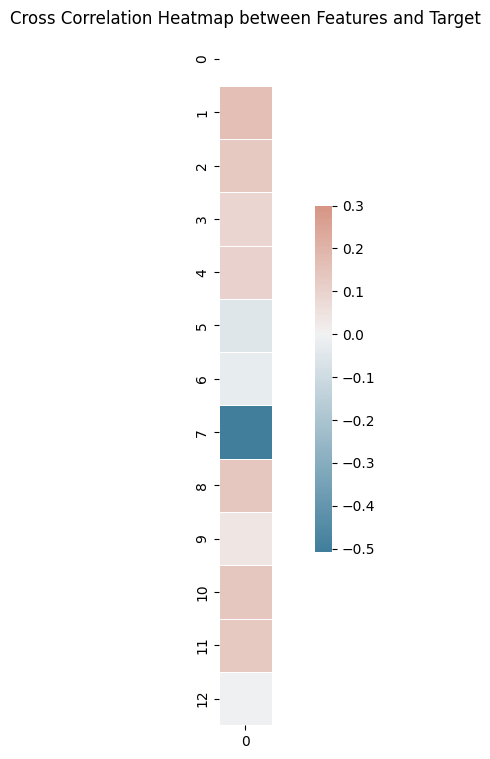

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = np.corrcoef(X.T, y)[0:X.shape[1], X.shape[1]:]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Cross Correlation Heatmap between Features and Target')
plt.show()

## Random forest classifier

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

Training Accuracy: 1.0
Testing Accuracy: 0.7747252747252747


## MLP

In [8]:
from MLP import MLP
import pytorch_lightning as pl

model = MLP()
trainer = pl.Trainer(max_epochs=35)
trainer.fit(model, train_dataloader)
trainer.test(model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 1.1 K 
--------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7417582273483276     │
│         test_loss         │    0.5107011795043945     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5107011795043945, 'test_accuracy': 0.7417582273483276}]

## KAN

In [10]:
from KAN import KAN
import pytorch_lightning as pl

model = KAN()
trainer = pl.Trainer(max_epochs=35)
trainer.fit(model, train_dataloader)
trainer.test(model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type     | Params
------------------------------------------
0 | kan1         | KANLayer | 221   
  | other params | n/a      | 2     
------------------------------------------
132       Trainable params
91        Non-trainable params
223       Total params
0.001     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7802197802197802     │
│         test_loss         │    0.5214938694959158     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5214938694959158, 'test_accuracy': 0.7802197802197802}]

train loss: 3.69e-01 | test loss: 4.38e-01 | reg: 8.73e+00 : 100%|██| 20/20 [00:03<00:00,  5.25it/s]


0.8176795840263367 0.7417582273483276


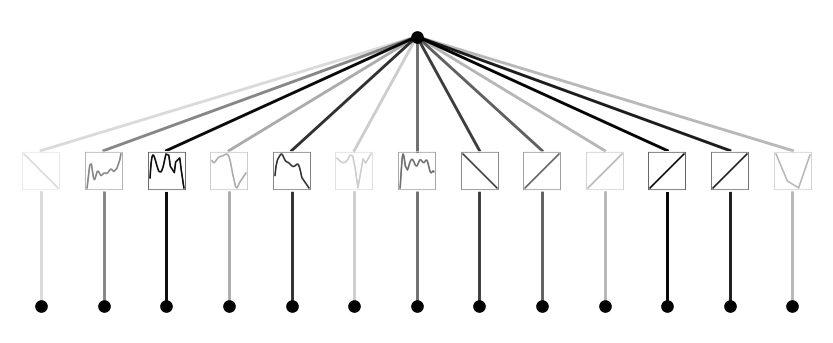

In [7]:
from kan import KAN

model = KAN(width=[13, 1], grid=10, k=3)

dataset = {
    'train_input': X_train_tensor,
    'train_label': y_train_tensor.view(-1, 1),
    'test_input': X_test_tensor,
    'test_label': y_test_tensor.view(-1, 1)
}

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));
print(results['train_acc'][-1], results['test_acc'][-1])

model.plot(beta=5, scale=1.05)

In [8]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with exp, r2=1.0000000000000013
fixing (0,1,0) with exp, r2=0.4654585171154705
fixing (0,2,0) with x^4, r2=0.3166958325652477
fixing (0,3,0) with sin, r2=0.7513154072850224
fixing (0,4,0) with abs, r2=0.7923024848318273
fixing (0,5,0) with x^4, r2=0.12585818760393824
fixing (0,6,0) with x^4, r2=0.2890145522209567
fixing (0,7,0) with x^4, r2=1.0000000000000016
fixing (0,8,0) with exp, r2=1.0000000000000013
fixing (0,9,0) with exp, r2=1.0000000000000016
fixing (0,10,0) with exp, r2=1.0000000000000009
fixing (0,11,0) with exp, r2=1.0000000000000016
fixing (0,12,0) with sin, r2=0.9997860803966617


In [9]:
formula = model.symbolic_formula()[0][0]
formula

-28.06*(0.31 - x_3)**4 + 1.92*(0.41 - x_6)**4 - 2.02*(0.47 - x_7)**4 - 0.03*(-x_8 - 0.97)**4 + 0.08*sin(6.03*x_13 + 7.78) - 0.16*sin(9.86*x_4 + 3.4) - 0.05*Abs(9.98*x_5 - 2.47) + 0.34

In [10]:
import numpy as np

# Test formula accuracy
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit = np.round(np.array(formula.subs('x_1', X[i,0])
                         .subs('x_2', X[i,1])
                         .subs('x_3', X[i,2])
                         .subs('x_4', X[i,3])
                         .subs('x_5', X[i,4])
                         .subs('x_6', X[i,5])
                         .subs('x_7', X[i,6])
                         .subs('x_8', X[i,7])
                         .subs('x_9', X[i,8])
                         .subs('x_10', X[i,9])
                         .subs('x_11', X[i,10])
                         .subs('x_12', X[i,11])
                         .subs('x_13', X[i,12])).astype(np.float64))
        correct += logit == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor([0.4959])
test acc of the formula: tensor([0.4890])


# Results and Discussion
 
This section presents a comparative analysis of the test metrics obtained from the Multilayer Perceptron (MLP) and the Kolmogorov-Arnold Network (KAN) models. The primary focus is on evaluating the models' performance in predicting patient readmissions based on historical hospital data.

The MLP model, with its sequential architecture, achieved a test accuracy of 0.742 and a test loss of 0.511. This model, as defined in MLP.py, consists of a series of linear and non-linear layers, culminating in a total of approximately 1.1K trainable parameters. The MLP's performance is commendable, considering the complexity of the task at hand.

On the other hand, the KAN model, as implemented in KAN.py, demonstrated superior performance with a test accuracy of 0.780 and a test loss of 0.521. Remarkably, the KAN model achieved these results with significantly fewer parameters to train, totaling only 223 parameters. This stark difference in the number of parameters underscores the efficiency and effectiveness of the KAN model in capturing the intrinsic geometry of the data with a minimalistic approach.
 
In addition to the MLP model, we also compared the KAN model's performance with that of a traditional machine learning approach, the Random Forest Classifier, which achieved a test accuracy of 0.775. This comparison further underscores the KAN model's superior performance, not only outpacing the traditional MLP model in terms of accuracy but also demonstrating higher efficiency and effectiveness than the Random Forest Classifier. With its fewer parameters, the KAN model streamlines the training process and minimizes the risk of overfitting. This efficiency, combined with its high accuracy, makes the KAN model an attractive option for tasks that demand high interpretability and generalization capabilities from limited datasets.
 
In conclusion, while both models present viable options for predicting patient readmissions, the KAN model's superior performance and efficiency make it a standout choice. Its ability to achieve higher accuracy with significantly fewer parameters offers a promising direction for future research and application in healthcare analytics.